# Autoencoder for Dimensionality Reduction in TensorFlow 2.0

### Author: Ivan Bongiorni, Data Scientist at GfK.

[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/).




Summary:


1.   What are Autoencoders?
2.   Why would you need an Autoencoder?
3.   Implementation and Training
4.   Extraction of the encoded dataframe
5.   Practical application

## 1. What are Autoencoders?

This tutorial is about a very specific form of Neural Networks: **Autoencoders**.  

There are several kinds of Autoencoders around, such as denoising Autoencoders or generative models (variational Autoencoders and GANs); they are all meant to accomplish very specific and different tasks. In this tutorial, I'll focus on their **dimensionality reduction** capabilities. Autoencoders for dimensionality reduction can be conceived as *the Neural Network-equivalent of Principal Component Analysis*.

The purpose of this class fo models is neither to learn how to classify observations, nor to predict a continuous output, but to compress, or simplify a dataset. For this reason, they are **unsupervised models**, differently from mainstream Deep Learning models. All the data that pass through an Autoencoder are unlabeled.




### Structure

If I had to explain what an Autoencoder is to my grand mother, I'd do it like this: it can be seen as a couple of funnels joined by the tip: in order to make data must flow from one extreme to the other, you must force them through the bottleneck in the middle.



More formally, it can be described as follows:

![alt text](https://cdn-images-1.medium.com/max/800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

(image from [towardsdatascience](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798))

Each Autoencoder is composed of two parts, an **Encoder** and a **Decoder**. The goal of the Encoder is to "compress" the dataset, representing its features with a number of nodes/variables that is narrower than the output layer; the goal of the Decoder is to learn how to reproduce, from the central encoded layer, the initial input values. Autoencoder are thus meant to reproduce the input data on the other extreme as accurately as possible.

At this point, you have the right to be puzzled. The first time I've read about this architecture, I was like "Wait a minute, what's the point of all that?!". And in fact, it's completely pointless. But reproducing the same dataset on the other side of the Network is a trick that allows for a dimensionality reduction.

The fact that the central hidden layers is narrower than the extremes forces the network to find the most efficient way to represent, at that layer, the same data in a more compressed form. The data that flow through that central layer can be seen as a form of dimensionality reduction.

## 2. Why would you need an Autoencoder?

Why would you need dimensionality reduction?

As you have probably learned from PCA, dimensionality reduction techniques are particularly useful when dealing with very complex and/or multicollinear datasets. Thanks to the "simplification" they perform, it is also possible to train Machine Learnign models on datasets otherwise too big for your run-down old laptop (joking).

### Ok, but why not good ol' PCA?

The advantages of this kind of Neural Network architecture over the more classical PCA is that with an Autoencoder you can potentially capture any non-linear pattern of your data. From PCA instead, you can extract factors that are only linearly associated with your actual variables, making the process of dimensionality reduction much more "rigid".

## 3. Implementation and Training



### Import data from UCI ML repository

The purpose of this dataset is to reduce the dimensionality of the University of Wisconsin's breast cancer dataset.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt

2.0.0-alpha0


In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", sep=",", header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Dataprep

Data preprocessing for Autoencoder require less effort than canonical Neural Networks. First, there is no need to split the data in train and test set, since my goal is just to produce a compressed version of the same dataset. Second, data do not require any labeling; we are in the field of unsupervised Machine Learning.

In [3]:
# get one-hot encoded target variable:
target = pd.get_dummies(df.iloc[:,1])
target = target.values.astype(np.float32) #convert to float32 for later

# I don't need the first two columns:
# the first is an id, the other is the target variable ('M'/'B')
df = df.iloc[:,2:]
df = df.values   # Turn to numpy object

In [4]:
# Normalize the data
# no need to use sklearn StandardScaler() this time, but you can if you want
def normalize(x):
    normalized = (x - np.mean(x))/(np.std(x))
    return normalized

for i in range(df.shape[1]):
    df[:,i] = normalize(df[:,i])

### Architecture

Given the shape of my training dataframe:

In [5]:
df.shape

(569, 30)

I must now choose an Autoencoder architecture. I want to compress a `(569, 30)` shaped dataset to a `(569, 10)` encoded version. This is an arbitrary choice. In real datascience problems the chioce depends from the nature of your specific dataset (and your specific needs), there is no general rule to determine the right number of encoded variables to be obtained.


In [6]:
# I choose the size of each layer

n_input_layer = df.shape[1]
n_hidden1 = 30
n_hidden2 = 15
n_hidden3 = 15

n_encoding_layer = 10

n_hidden5 = 15
n_hidden6 = 15
n_hidden7 = 30
n_output_layer = n_input_layer  # size of output layer = size of input layer, of course

As you can see, the architecture of the Network si perfectly symmetric. Of course, Encoder and Decoder don't need to be the exact mirror image of each other.

In [7]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import elu

Autoencoder = tf.keras.models.Sequential([
    # ENCODER
    Dense(n_input_layer, input_shape = (n_input_layer,), activation = elu),   # Input layer    
    Dense(n_hidden1, activation = elu), # hidden layer 1    
    Dense(n_hidden2, activation = elu), # hidden layer 2    
    Dense(n_hidden3, activation = elu), # hidden layer 3
    
    # CENTRAL LAYER
    Dense(n_encoding_layer, activation = elu, name = 'central_layer'), 
    
    # DECODER
    Dense(n_hidden5, activation = elu), # hidden layer 5
    Dense(n_hidden6, activation = elu), # hidden layer 6
    Dense(n_hidden7, activation = elu), # hidden layer 7
    Dense(n_output_layer, activation = elu)  # Output layer
])

Now that the Network's structure is ready, let me define other hyperparameters:

In [8]:
# number of epochs
n_epochs = 5000

# Loss: mean squared error
loss = tf.keras.losses.MeanSquaredError()

# Adam Optimizer
optimizer = tf.optimizers.Adam(learning_rate = 0.0005)

### Training

In [9]:

loss_history = []  # save loss improvement

for epoch in range(n_epochs):
    
    with tf.GradientTape() as tape:
        current_loss = loss(Autoencoder(df), df)
    
    gradients = tape.gradient(current_loss, Autoencoder.trainable_variables)    # get the gradient of the loss function
    optimizer.apply_gradients(zip(gradients, Autoencoder.trainable_variables))  # update the weights
    
    loss_history.append(current_loss.numpy())  # save current loss in its history
    
    # show loss improvement every 200 epochs
    if (epoch+1) % 200 == 0:
        print(str(epoch+1) + '.\tLoss: ' + str(current_loss.numpy()))
#
print('\nEncoding complete')

200.	Loss: 0.2983798086643219
400.	Loss: 0.16014118492603302
600.	Loss: 0.11733168363571167
800.	Loss: 0.09321168065071106
1000.	Loss: 0.07829537242650986
1200.	Loss: 0.07143492251634598
1400.	Loss: 0.06630369275808334
1600.	Loss: 0.06210746988654137
1800.	Loss: 0.059432562440633774
2000.	Loss: 0.057390931993722916
2200.	Loss: 0.05561588332056999
2400.	Loss: 0.05405626446008682
2600.	Loss: 0.052680548280477524
2800.	Loss: 0.05113258957862854
3000.	Loss: 0.04885231703519821
3200.	Loss: 0.04681725054979324
3400.	Loss: 0.045288633555173874
3600.	Loss: 0.04415624216198921
3800.	Loss: 0.04331396520137787
4000.	Loss: 0.042595453560352325
4200.	Loss: 0.0420219786465168
4400.	Loss: 0.04152001813054085
4600.	Loss: 0.04105399176478386
4800.	Loss: 0.04111744463443756
5000.	Loss: 0.04028546065092087

Encoding complete


The computation of `current_loss` deserves attention.

As explained above, an Autoencoder doesn't require a dependent variable, i.e. the loss function will not contain any "test data". We only need to train the Autoencoder to replicate the input data at the output layer (like comparing the initial dataset with a copy of itself), that's why we are minimizing the distance between the Network's output `Autoencoder(df)` and the actual `df`.

### Check compression improvements visually

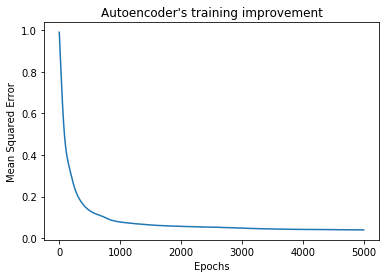

In [10]:
plt.plot(loss_history)
plt.title("Autoencoder's training improvement")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

## 4. Extraction of the encoded dataframe

Now that the training of the Autoencoder is done, we can extract our data at the central layer, where they received the strongest compression.

In order to do that, we must create an apposite **extraction function** using the **Keras backend submodule**. We use it to implement a Keras function that takes the Autoencoder's input layer as input, and returns the outcome of the central layer as output.

In [11]:
from tensorflow.keras import backend as K

# create a Keras function
extract_encoded_data = K.function(inputs = Autoencoder.layers[0].input, 
                                  outputs = Autoencoder.layers[4].output)

# extract encoded dataframe
encoded_dataframe = extract_encoded_data(df)

print(encoded_dataframe.shape)

(569, 10)


I defined `Autoencoder.layers[4]` as the output of that function, since `.layers[4]` is the index of the central layer that compressed my initial dataframe.

## 5. Practical application

Now that we have an encoded version of our initial dataset, we can use it for our Machine Learning task. Let's implement a Neural Network Classifier and train it on the encoded dataset! Because I want to save time, I'll make it in the most minimal way I know; however, if you need more details, please check [my other tutorials](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial) in which all of these passages are explained in more detail.

In [12]:

# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_dataframe, target, test_size=0.25, random_state=173)

# Scaling of data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model architecture - layers: [10, 5, 5, 2]
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import elu, softmax

model = tf.keras.models.Sequential([
    Dense(10, input_shape = (X_train.shape[1], ), activation = elu), 
    Dense(5, activation = elu), 
    Dense(5, activation = elu),     
    Dense(2, activation = softmax)])

bce_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.optimizers.Adam(learning_rate = 0.001)

# Training
for epoch in range(500):
    with tf.GradientTape() as tape:
        current_loss = bce_loss(model(X_train), y_train)    
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Let's check its predictions:

In [13]:
prediction = model.predict(X_test)  # prediction of test data
prediction = np.argmax(prediction, axis=1)  # reverse one-hot encoding
testdata = np.argmax(y_test, axis=1)  # reverse for target data too

from sklearn.metrics import confusion_matrix
CM = confusion_matrix(prediction, testdata)
print(CM)

[[86  1]
 [ 3 53]]


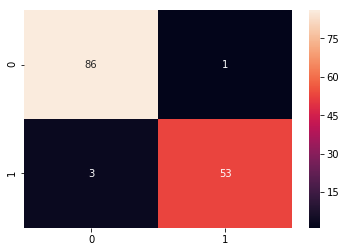

In [14]:
import seaborn
seaborn.heatmap(CM, annot=True)
plt.show()

In [15]:
print('Test Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

Test Accuracy: 0.972027972027972


Cool, I have achieved pretty much the same accuracy that I reached with the [full-Batch model in my first Notebook](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow2.0_01_basic_Classifier.ipynb)! But this time using a much lighter model trained on a compressed version of the original dataframe.

This is the power of Autoencoders. You'll find that computational times will be much slower, and with very similar results. In case of very multicollinear datasets, you might even find a significant improvement in your model performance.

...

PS: If you want to encode many dataframes, make sure you remember [how to save and restore it](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow_2.0_03_Save_and_Restore_models.ipynb)!